In [1]:
import sys; sys.path.append('/home/clair/wwa')
from wwa import *

---
## **Shapefiles**

In [1]:
# load Koppen-Geiger gridded data (& trim down to a more useful size)
kg = xr.open_dataset("kg_classifications.nc").kg_cat.sel(lat = slice(5,60), lon = slice(60,150))

# select India & Bangladesh regions
rm = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask_3D(kg.lon, kg.lat).sel(region = [98,99]).sum("region")
rm = rm.where(rm == 1).dropna("lon", "all").dropna("lat", "all")

kg_arr = kg.where(rm == 1)

df = pd.read_csv("kg_legend.csv", index_col = "cat")

rm = kg_arr.where(kg_arr < 4)

In [1]:
# plot the regions to decide which areas we want to use
fig, ax = plt.subplots(dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, figsize = (6,5))
[kg_arr.where(kg_arr == r).plot(ax = ax, label = df.loc[r, "desc"], cmap = "Greens", add_colorbar = False) for r in range(1,4)]
[kg_arr.where(kg_arr == r).plot(ax = ax, label = df.loc[r, "desc"], cmap = "Oranges", add_colorbar = False) for r in range(4,8)]
# [kg_arr.where(kg_arr == r).plot(ax = ax, label = df.loc[r, "desc"], cmap = "Blues", add_colorbar = False) for r in range(8,16)]
# [kg_arr.where(kg_arr == r).plot(ax = ax, label = df.loc[r, "desc"], cmap = "Purples", add_colorbar = False) for r in range(16,28)]
# [kg_arr.where(kg_arr == r).plot(ax = ax, label = df.loc[r, "desc"], cmap = "Reds", add_colorbar = False) for r in range(28,30)]

ax.coastlines(lw = 2)
ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5)    
ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.1)

plt.legend(handles = [matplotlib.patches.Patch(color = "green", label = "Tropical", alpha = 0.5)], 
           edgecolor = "w", loc = "lower right")

In [1]:
## CONVERT TO POLYGON
from xrspatial.experimental import polygonize

# define affine transform to correct coordinates
res = list(set(np.diff(kg.lat).round(5)))[0]
transform = np.array([res,0,rm.lon.min().values - res/2,0,res,rm.lat.min().values + res/2])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~# convert xarray data to polygon, remove any interior holes
rm_ext = xr.ones_like(kg_arr).where(kg_arr < 4)

rm_poly = polygonize(rm_ext, mask = ~np.isnan(rm_ext), return_type = "geopandas", transform = transform)
rm_poly["geometry"] = rm_poly.geometry.apply(lambda p: Polygon(list(p.exterior.coords)))
rm_poly = rm_poly[rm_poly.geometry.area == rm_poly.geometry.area.max()]
rm_poly = rm_poly.simplify(res)

rm_poly.set_crs(epsg = 4326).to_file("sf_indiabangladesh-tropical-exterior")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# polygon of semi-arid region
rm_int = xr.ones_like(kg_arr).where(kg_arr >=4).where(kg_arr <8)

sa_poly = polygonize(rm_int, mask = ~np.isnan(rm_int), return_type = "geopandas", transform = transform)
sa_poly["geometry"] = sa_poly.geometry.apply(lambda p: Polygon(list(p.exterior.coords))).simplify(res)
sa_poly = sa_poly.iloc[[1]]

sa_poly.set_crs(epsg = 4326).to_file("sf_indiabangladesh-tropical-hole")

In [1]:
fig, ax = plt.subplots(dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, figsize = (6,5))
[kg_arr.where(kg_arr == r).plot(ax = ax, label = df.loc[r, "desc"], cmap = "Greens", add_colorbar = False) for r in range(1,4)]
[kg_arr.where(kg_arr == r).plot(ax = ax, label = df.loc[r, "desc"], cmap = "Oranges", add_colorbar = False) for r in range(4,8)]

ax.coastlines(lw = 2)
ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5)    
ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.1)

gpd.read_file("sf_indiabangladesh-tropical-exterior").boundary.plot(ax = ax, color = "darkred")
gpd.read_file("sf_indiabangladesh-tropical-hole").boundary.plot(ax = ax, color = "darkblue")

---
## **CORDEX pre-processing**
_data downloaded via Synda and pre-processed on Imperial's HPC_

Missing: EA-hw_tx4x-ib-ext_WAS-44_IPSL-CM5A-LR_r1_RegCM4-4.dat

### **India & Bangladesh**

_RegCM4-4 has no land-sea mask_

In [11]:
sf_ext = gpd.read_file("sf_indiabangladesh-tropical-exterior")
sf_int = gpd.read_file("sf_indiabangladesh-tropical-hole")

fl = glob.glob("../synda/data/CORDEX/WAS-44/*/*/*/day/")
for fpath in fl:
    
    tasmax_fl = sorted(glob.glob(fpath+"tasmax/*"))
    new_fnm = re.sub("_[0-9]{8}-", "_"+tasmax_fl[0][-20:-12]+"-", tasmax_fl[-1].split("/")[-1])
    print(str(fl.index(fpath)+1).rjust(2, "0")+"/"+str(len(fl))+" "+new_fnm)
    if len(glob.glob("cordex/EA-hw_tx4x-ib-ext_"+new_fnm.split("_")[1]+"_"+cordex_model(new_fnm)+".dat")) > 0: continue
    
    # load max temps
    da = convert_units_to(xr.open_mfdataset(tasmax_fl).tasmax, "degC")
    
    if "rlon" in da.dims:
        x_dim, y_dim = ["rlon", "rlat"]
    elif "x" in da.dims:
        x_dim, y_dim = ["x", "y"]
    
    # get area
    sp_mask = np.logical_and(np.logical_and(da.lat > 5, da.lat < 60), np.logical_and(da.lon > 60, da.lon < 150))
    sp_mask = sp_mask.where(sp_mask == 1).dropna(x_dim, "all").dropna(y_dim, "all")
    
    # trim data to area required
    da = da.sel({x_dim : sp_mask[x_dim], y_dim : sp_mask[y_dim]})
    
    # spatial pattern over larger rectangular region (obs period only)
    sp = da.sel(time = slice("1980", "2022")).groupby("time.month")[4].mean("time")
    sp.to_netcdf("cordex/sp-"+re.sub("[0-9]{8}-[0-9]{8}", "19800101-20221231", new_fnm))
    
    # load land-sea mask
    lsm_fnm = glob.glob(re.sub("day/", "fx/sftlf/*.nc", re.sub("r[0-9]+i1p1", "*", fpath)))
    if len(lsm_fnm) > 0:
        lsm = xr.open_dataset(lsm_fnm[0]).sftlf
        lsm = xr.ones_like(lsm).where(lsm >= 0.5).sel({x_dim : sp_mask[x_dim], y_dim : sp_mask[y_dim]})
        da = da.where(lsm == 1)
    else:
        print("No LSM: "+fpath)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # create regionmasks
    rm_ext = regionmask.mask_3D_geopandas(sf_ext, da.lon, da.lat, drop = False).squeeze(drop = True)
    rm_int = regionmask.mask_3D_geopandas(sf_int, da.lon, da.lat, drop = False).squeeze(drop = True)
    rm_tropical = np.logical_xor(rm_ext, rm_int)
    
    # seasonal cycle over the study region (obs period only)
    sc_ext = da.where(rm_ext == 1).mean([x_dim, y_dim]).sel(time = slice("1980", "2022")).groupby("time.dayofyear").mean()
    sc_ext.to_netcdf("cordex/sc-ib-ext-"+re.sub("[0-9]{8}-[0-9]{8}", "19800101-20221231", new_fnm))
    
    sc_trop = da.where(rm_tropical == 1).mean([x_dim, y_dim]).sel(time = slice("1980", "2022")).groupby("time.dayofyear").mean()
    sc_trop.to_netcdf("cordex/sc-ib-trop-"+re.sub("[0-9]{8}-[0-9]{8}", "19800101-20221231", new_fnm))
    
    # time series: April maximum of 4-day rolling average of tasmax
    tx4x_ext = da.where(rm_ext == 1).mean([x_dim, y_dim]).rolling(time = 4).mean().groupby("time.month")[4].resample(time = "AS-JAN").max()
    tx4x_trop = da.where(rm_tropical == 1).mean([x_dim, y_dim]).rolling(time = 4).mean().groupby("time.month")[4].resample(time = "AS-JAN").max()
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    csv_fnm = "cordex/EA-hw_tx4x-ib-ext_"+new_fnm.split("_")[1]+"_"+cordex_model(new_fnm)+".dat"
    if len(csv_fnm) >= 65: print("! Filename too long: ", csv_fnm)
        
    # create  header lines
    str1 = "# contact :: CORDEX "+cordex_model(new_fnm)+" tx4x-apr in India/Bangladesh - East Asia spring heatwaves 2023, c.barnes22@imperial.ac.uk"
    str2 = "# tx4x-apr [degC] annual maximum of 4-day rolling tasmax during April in India/Bangladesh"+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year tx4x-apr"
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    tx4x_ext.assign_coords(time = tx4x_ext.time.dt.year).dropna("time", "any").to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    csv_fnm = re.sub("-ext", "-trop", csv_fnm)
    
    str2 = re.sub("in India", "in tropical India", str2)
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    tx4x_trop.assign_coords(time = tx4x_ext.time.dt.year).dropna("time", "any").to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

3

### **Laos & Thailand**

In [ ]:
for fpath in glob.glob("../synda/data/CORDEX/SEA-22/*/*/*/day/"):
    
    tasmax_fl = sorted(glob.glob(fpath+"tasmax/*"))
    new_fnm = re.sub("_[0-9]{8}-", "_"+tasmax_fl[0][-20:-12]+"-", tasmax_fl[-1].split("/")[-1])
    print(new_fnm)
    if len(glob.glob("cordex/EA-hw_tx4x-tl_"+new_fnm.split("_")[1]+"_"+cordex_model(new_fnm)+".dat")) > 0: continue
    
    # load max temps
    da = convert_units_to(xr.open_mfdataset(tasmax_fl).tasmax, "degC")
    
    if "rlon" in da.dims:
        x_dim, y_dim = ["rlon", "rlat"]
    elif "x" in da.dims:
        x_dim, y_dim = ["x", "y"]
    
    # get area
    sp_mask = np.logical_and(np.logical_and(da.lat > 5, da.lat < 60), np.logical_and(da.lon > 60, da.lon < 150))
    sp_mask = sp_mask.where(sp_mask == 1).dropna(x_dim, "all").dropna(y_dim, "all")
    
    # trim data to area required
    da = da.sel({x_dim : sp_mask[x_dim], y_dim : sp_mask[y_dim]})
    
    # spatial pattern over larger rectangular region (obs period only)
    sp = da.sel(time = slice("1980", "2022")).groupby("time.month")[4].mean("time")
    sp.to_netcdf("cordex/sp-"+re.sub("[0-9]{8}-[0-9]{8}", "19800101-20221231", new_fnm))
    
    # load land-sea mask
    lsm_fnm = glob.glob(re.sub("day/", "fx/sftlf/*.nc", re.sub("r[0-9]+i1p1", "*", fpath)))
    if len(lsm_fnm) > 0:
        lsm = xr.open_dataset(lsm_fnm[0]).sftlf
        lsm = xr.ones_like(lsm).where(lsm >= 0.5).sel({x_dim : sp_mask[x_dim], y_dim : sp_mask[y_dim]})
        da = da.where(lsm == 1)
    else:
        print("No LSM: "+fpath)

    # create regionmasks
    rm = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask_3D(da.lon, da.lat).sel(region = [91,92]).sum("region")

    # seasonal cycle over the study region (obs period only)
    sc = da.where(rm == 1).mean([x_dim, y_dim]).sel(time = slice("1980", "2022")).groupby("time.dayofyear").mean()
    sc.to_netcdf("cordex/sc-"+re.sub("[0-9]{8}-[0-9]{8}", "19800101-20221231", new_fnm))
    
    # time series: April maximum of 4-day rolling average of tasmax
    tx4x = da.where(rm == 1).mean([x_dim, y_dim]).rolling(time = 4).mean().groupby("time.month")[4].resample(time = "AS-JAN").max()
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    csv_fnm = "cordex/EA-hw_tx4x-tl_"+new_fnm.split("_")[1]+"_"+cordex_model(new_fnm)+".dat"
    if len(csv_fnm) >= 65: print("! Filename too long: ", csv_fnm)
        
    # create  header lines
    str1 = "# contact :: CORDEX "+cordex_model(new_fnm)+" tx4x-apr in Thailand & Laos - East Asia spring heatwaves 2023, c.barnes22@imperial.ac.uk"
    str2 = "# tx4x-apr [degC] annual maximum of 4-day rolling tasmax during April in Thailand & Laos"+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year tx4x-apr"
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    tx4x.assign_coords(time = tx4x.time.dt.year).dropna("time", "any").to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)


### **GMST data for CORDEX driving models**

In [63]:
# Copy CMIP5 GMST files across
for gcm in list(set(["_rcp85_".join(cordex_model(fnm).split("_")[:2]) for fnm in glob.glob("cordex/*.nc")])):
    
    gsat_fnm = glob.glob("../00_gsat/cmip5_smoothed-gsat*"+gcm+".dat")
    print(gsat_fnm)
    
    if len(gsat_fnm) == 0:
        print("No GSAT:", gcm)
        continue

    gsat_fnm = gsat_fnm[0]
    new_fnm = "ts/EA-hw_"+re.sub(".+Amon", "gsat", gsat_fnm.split("/")[-1])
    if len(new_fnm.split("/")[-1]) > 65: print("Filename too long:", new_fnm)
    
    ! cp $gsat_fnm $new_fnm

['../00_gsat/cmip5_smoothed-gsat_EC-EARTH_rcp85_r12.dat']
['../00_gsat/cmip5_smoothed-gsat_MIROC5_rcp85_r1.dat']
['../00_gsat/cmip5_smoothed-gsat_MPI-ESM-MR_rcp85_r1.dat']
['../00_gsat/cmip5_smoothed-gsat_CSIRO-Mk3-6-0_rcp85_r1.dat']
['../00_gsat/cmip5_smoothed-gsat_NorESM1-M_rcp85_r1.dat']
['../00_gsat/cmip5_smoothed-gsat_CNRM-CM5_rcp85_r1.dat']
['../00_gsat/cmip5_smoothed-gsat_CanESM2_rcp85_r1.dat']
['../00_gsat/cmip5_smoothed-gsat_IPSL-CM5A-LR_rcp85_r1.dat']
['../00_gsat/cmip5_smoothed-gsat_IPSL-CM5A-MR_rcp85_r1.dat']
['../00_gsat/cmip5_smoothed-gsat_MPI-ESM-LR_rcp85_r1.dat']
['../00_gsat/cmip5_smoothed-gsat_HadGEM2-ES_rcp85_r1.dat']
['../00_gsat/cmip5_smoothed-gsat_GFDL-ESM2M_rcp85_r1.dat']


### **Remove extra column from time series**
_Forgot to drop unnecessary coordinates before saving, so loop over files & remove 'height' column_

In [61]:
for fnm in glob.glob("ts/*.dat"):
    
    # load actual data
    df = pd.read_csv(fnm, comment = "#", sep = " ", header = None, index_col = 0)
    
    if len(df.columns) == 1: continue
        
    # load header rows
    with open(fnm) as f:
        str1, str2, head = [re.sub("\n", "", s) for s in f.readlines()[:3]]
    
    # recreate filename
    ! echo "$str1 " > $fnm
    ! echo "$str2" >> $fnm
    ! echo "$head" >> $fnm
    
    df[[2]].to_csv(fnm, sep = " ", mode = "a", header = False)

---
## **Model validation**

### **Spatial patterns**

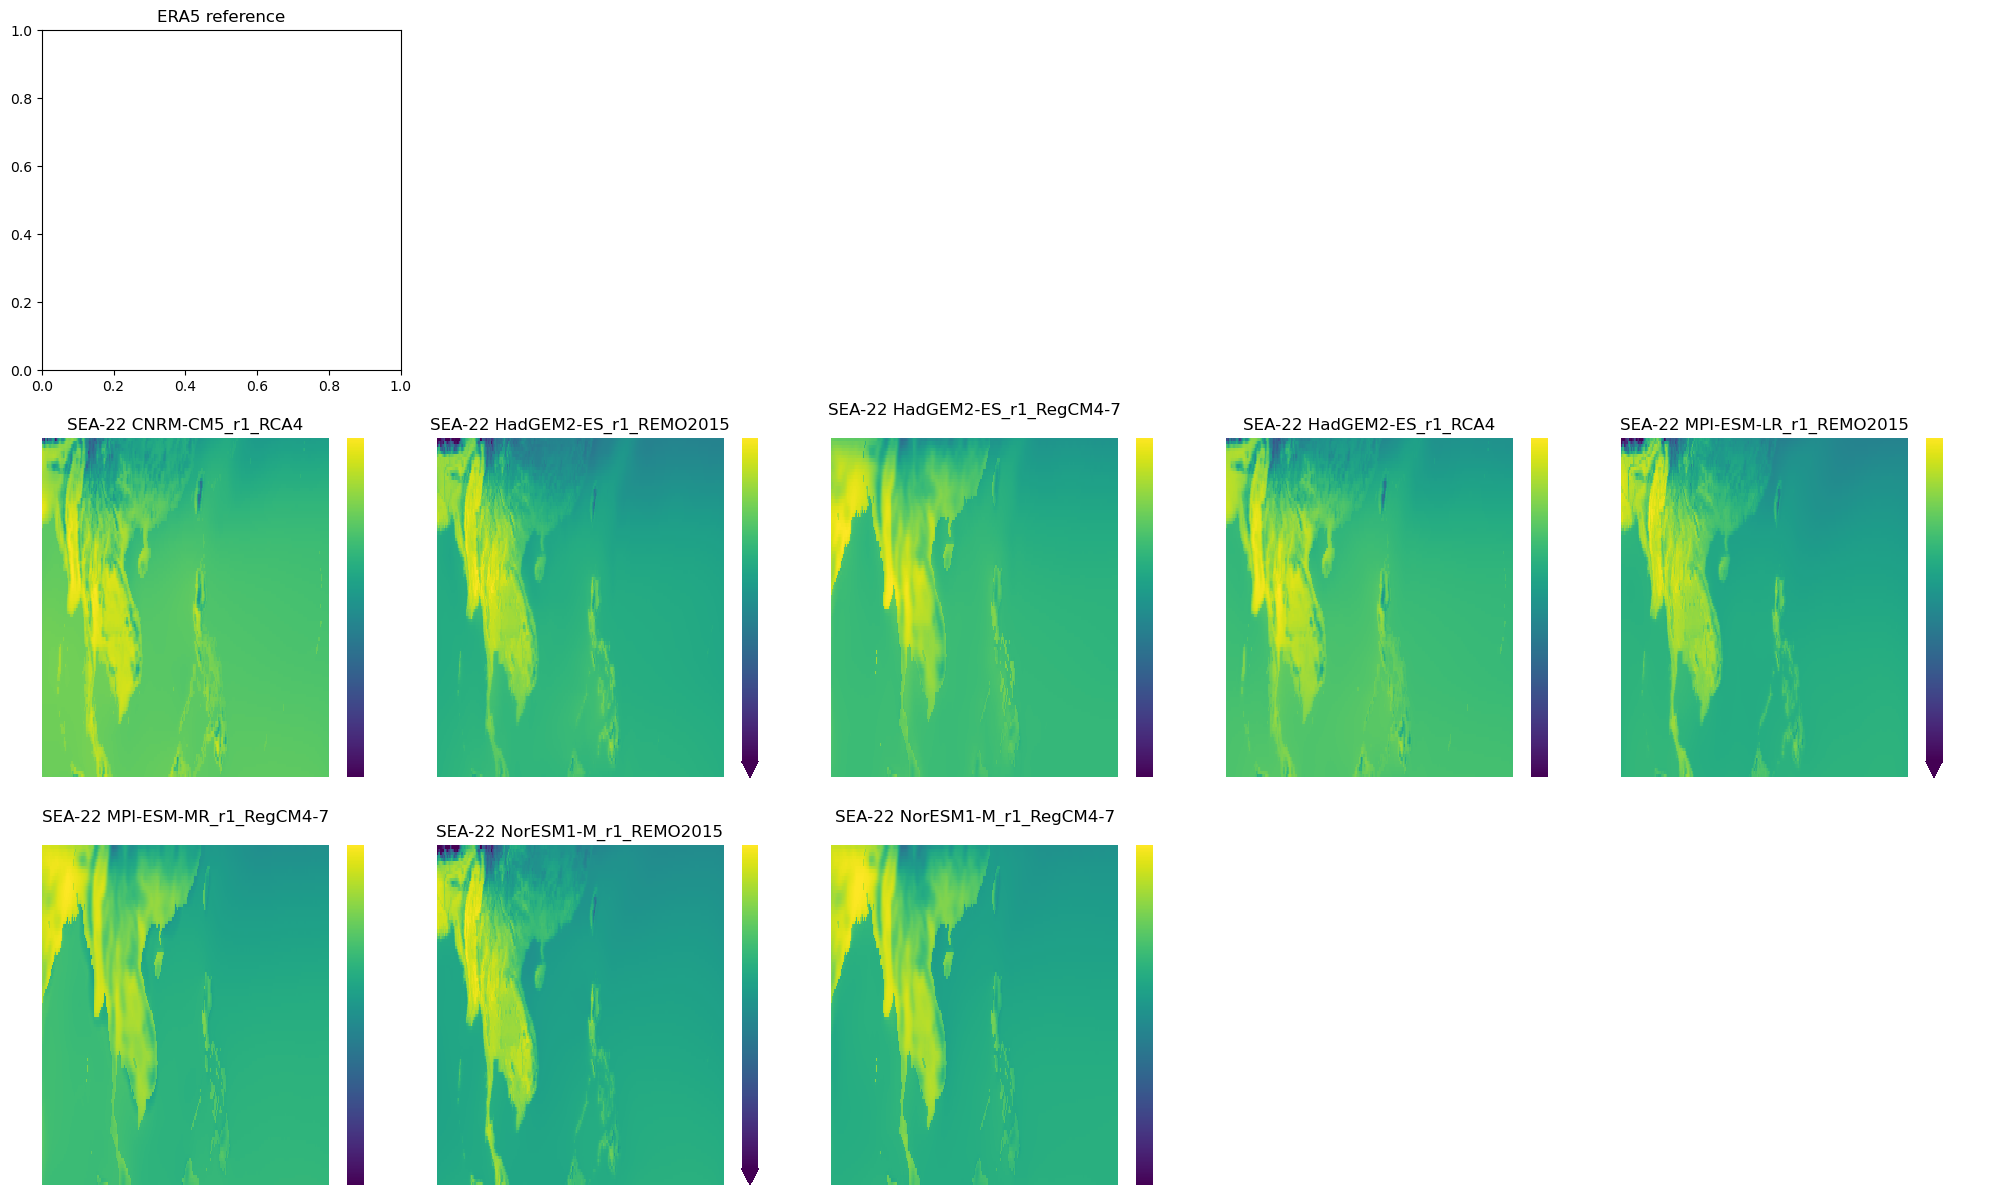

In [183]:
fl = sorted(glob.glob("cordex/sp-tasmax_SEA-*"))
nc = 5

sf_ext = gpd.read_file("sf_indiabangladesh-tropical-exterior")
sf_tl = gpd.read_file("sf_ThlndLaos")

nr = int(np.ceil(len(fl) / nc)+1)
plot_kws = {"cmap" : "viridis", "vmin" : 0}

fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*5,nr*5), dpi = 100)#, subplot_kw = {"projection" : cartopy.crs.PlateCarree(), "extent" : (70,107,5,27)})
plt.subplots_adjust(wspace = 0.1)

# reference patterns from ERA5
# era5.plot(ax = axs[0,0], add_colorbar = False, **plot_kws)
axs[0,0].set_title("ERA5 reference")

# turn off remaining axes in top row
# axs[0,0].coastlines()
# sf_ext.boundary.plot(ax = axs[0,0], color = "darkred")
# sf_tl.boundary.plot(ax = axs[0,0], color = "darkred")

for ax in axs[0,1:]: ax.set_axis_off()

# plot individual runs
for i in range(len(fl)):
    
    fnm = fl[i]
    da = xr.open_dataset(fnm).tasmax
    
    ax = fig.axes[i+nc]
    ax.set_axis_off()
    da.plot(ax = ax,  **plot_kws)
    # cbar = ax.pcolormesh(da.lon, da.lat, da, **plot_kws)
    ax.set_title(fnm.split("_")[1]+" "+cordex_model(fnm))
    # ax.coastlines()
    # sf.boundary.plot(ax = ax, color = "darkred")
    
if len(fl) < ((nr-1) * nc):
    for ax in fig.axes[len(fl)+nc:]: ax.set_axis_off()
    
plt.savefig("fig/spatial_tasmax_cordex-SEA.png")

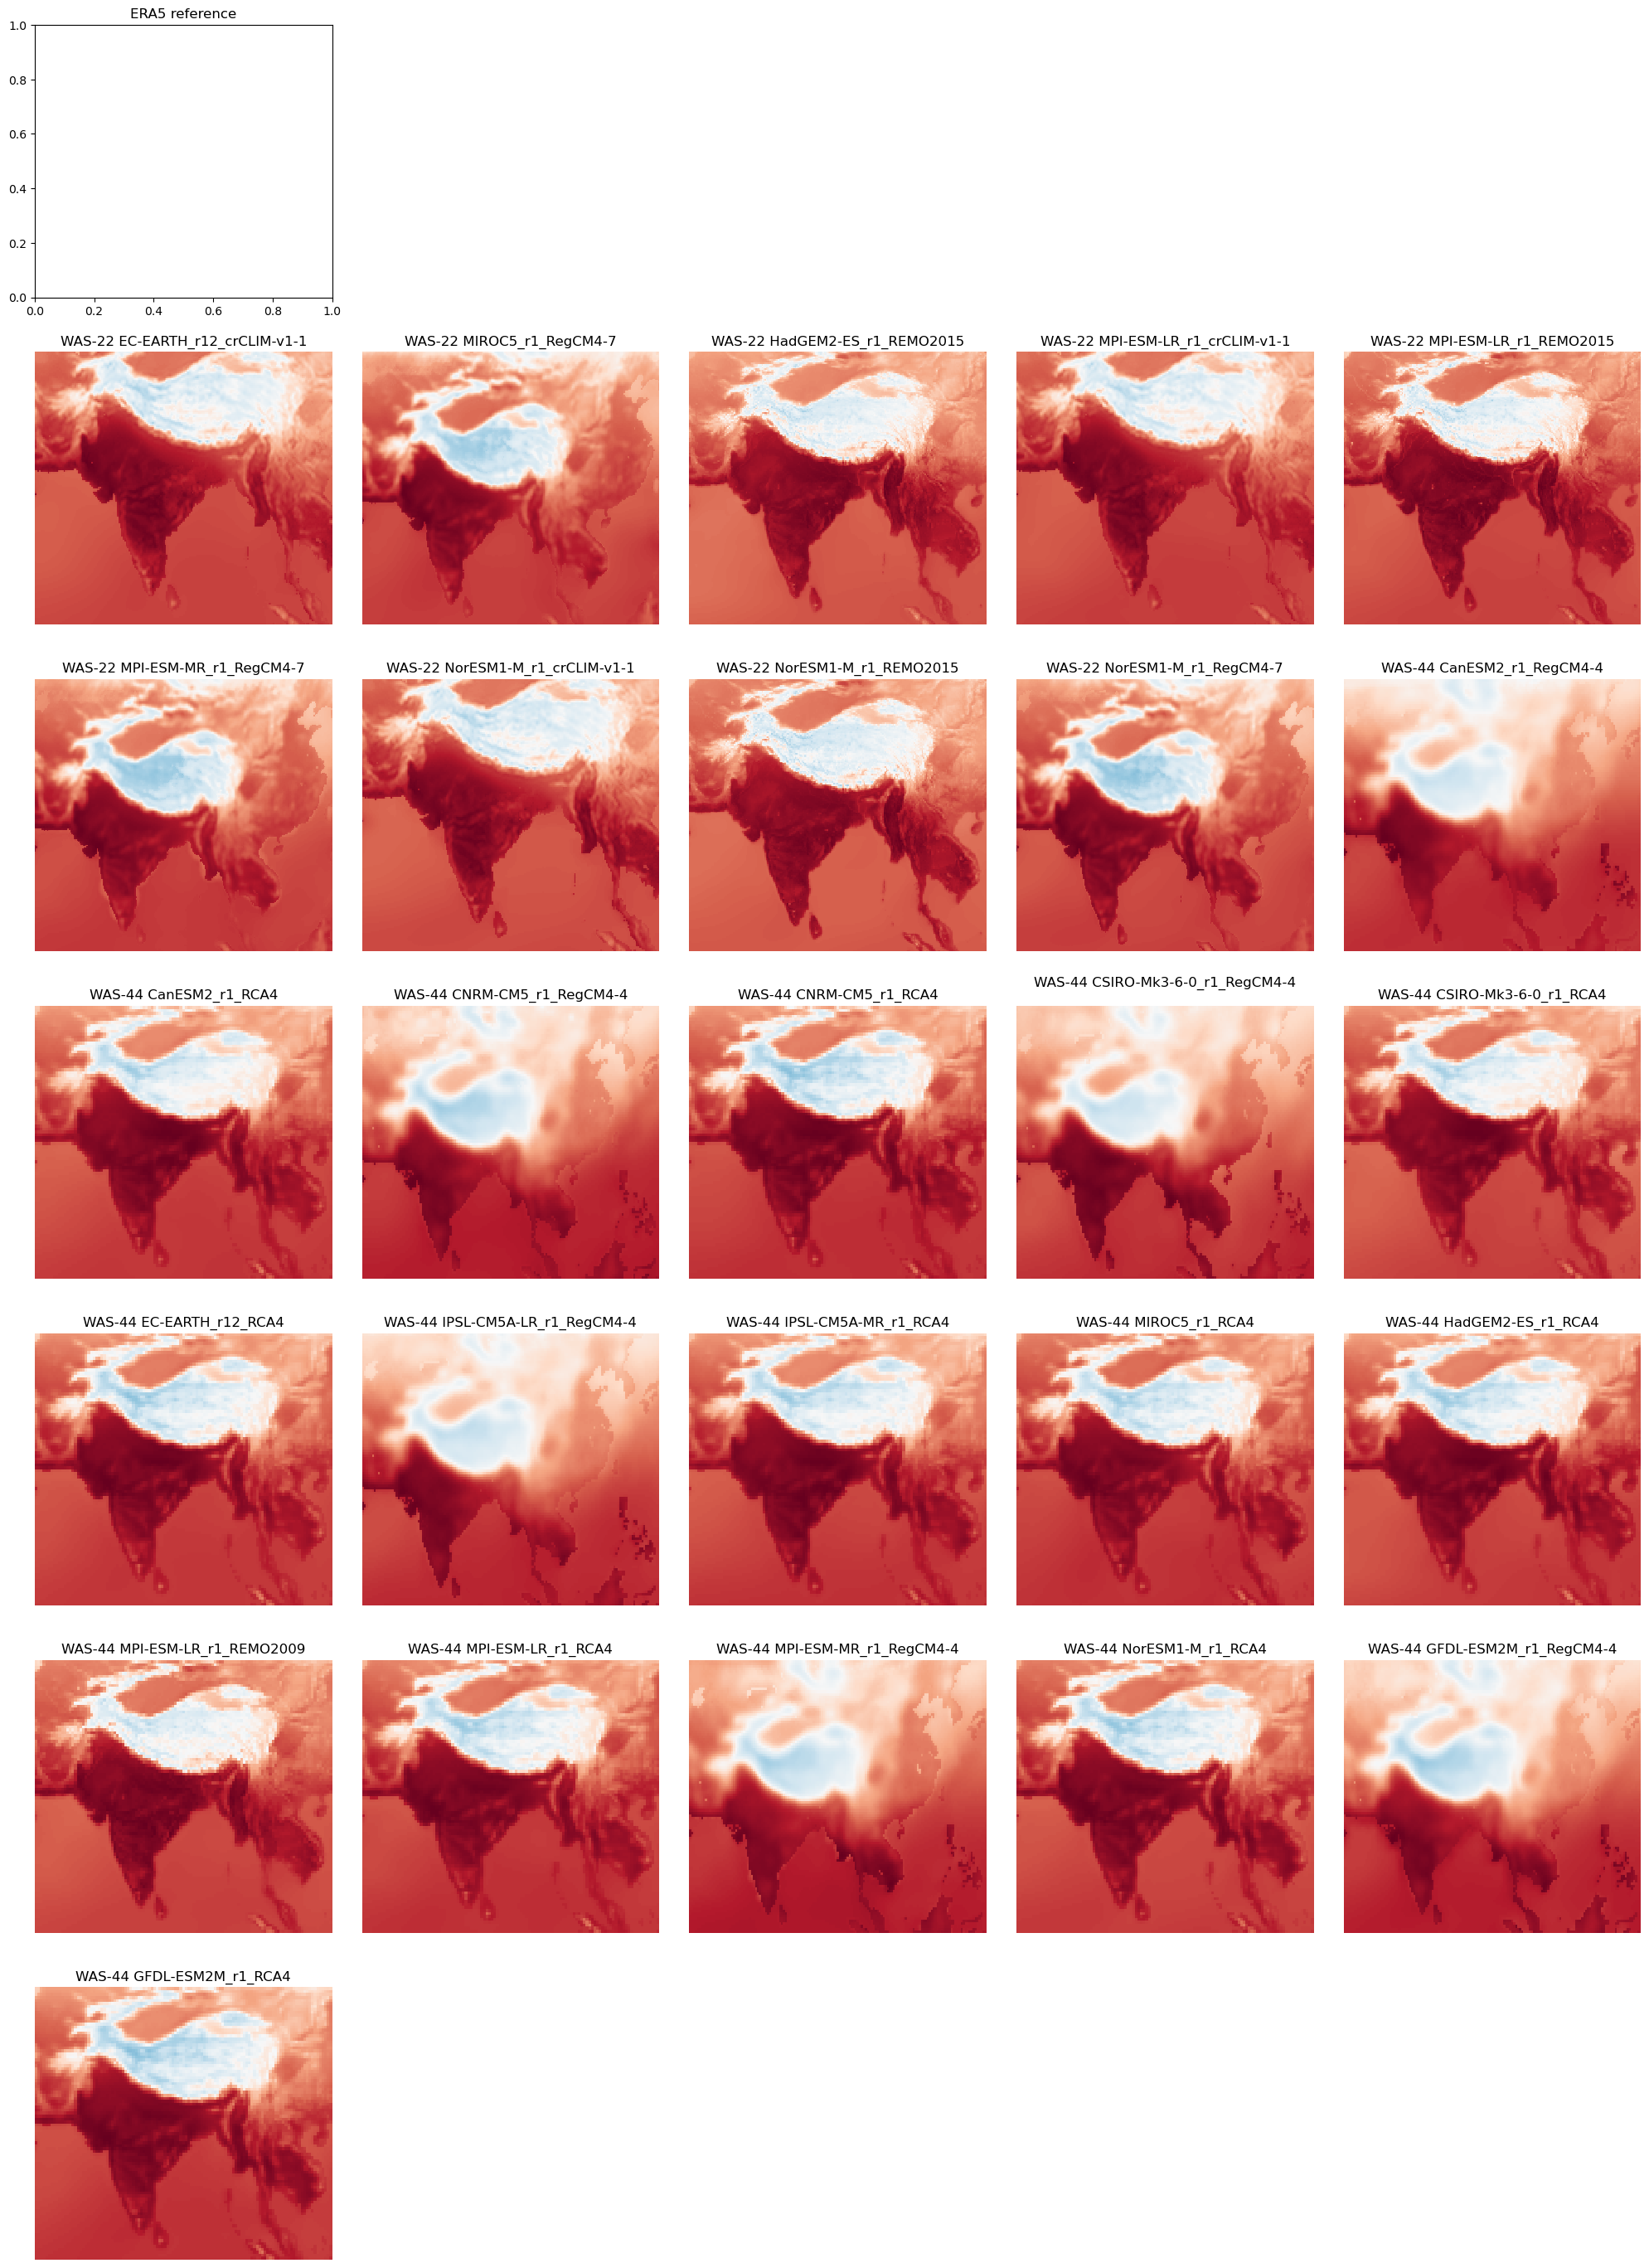

In [175]:
fl = sorted(glob.glob("cordex/sp-tasmax_WAS-*"))
nc = 5

sf_ext = gpd.read_file("sf_indiabangladesh-tropical-exterior")
sf_tl = gpd.read_file("sf_ThlndLaos")

nr = int(np.ceil(len(fl) / nc)+1)
plot_kws = {"cmap" : "RdBu_r"}

fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*5,nr*5), dpi = 100)#, subplot_kw = {"projection" : cartopy.crs.PlateCarree(), "extent" : (70,107,5,27)})
plt.subplots_adjust(wspace = 0.1)

# reference patterns from ERA5
# era5.plot(ax = axs[0,0], add_colorbar = False, **plot_kws)
axs[0,0].set_title("ERA5 reference")

# turn off remaining axes in top row
# axs[0,0].coastlines()
# sf_ext.boundary.plot(ax = axs[0,0], color = "darkred")
# sf_tl.boundary.plot(ax = axs[0,0], color = "darkred")

for ax in axs[0,1:]: ax.set_axis_off()

# plot individual runs
for i in range(len(fl)):
    
    fnm = fl[i]
    da = xr.open_dataset(fnm).tasmax
    
    ax = fig.axes[i+nc]
    ax.set_axis_off()
    da.plot(ax = ax, **plot_kws, add_colorbar = False)
    # cbar = ax.pcolormesh(da.lon, da.lat, da, **plot_kws)
    ax.set_title(fnm.split("_")[1]+" "+cordex_model(fnm))
    # ax.coastlines()
    # sf.boundary.plot(ax = ax, color = "darkred")
    
if len(fl) < ((nr-1) * nc):
    for ax in fig.axes[len(fl)+nc:]: ax.set_axis_off()
    
plt.savefig("fig/spatial_tasmax_cordex-WAS.png")

### **Seasonal cycle**

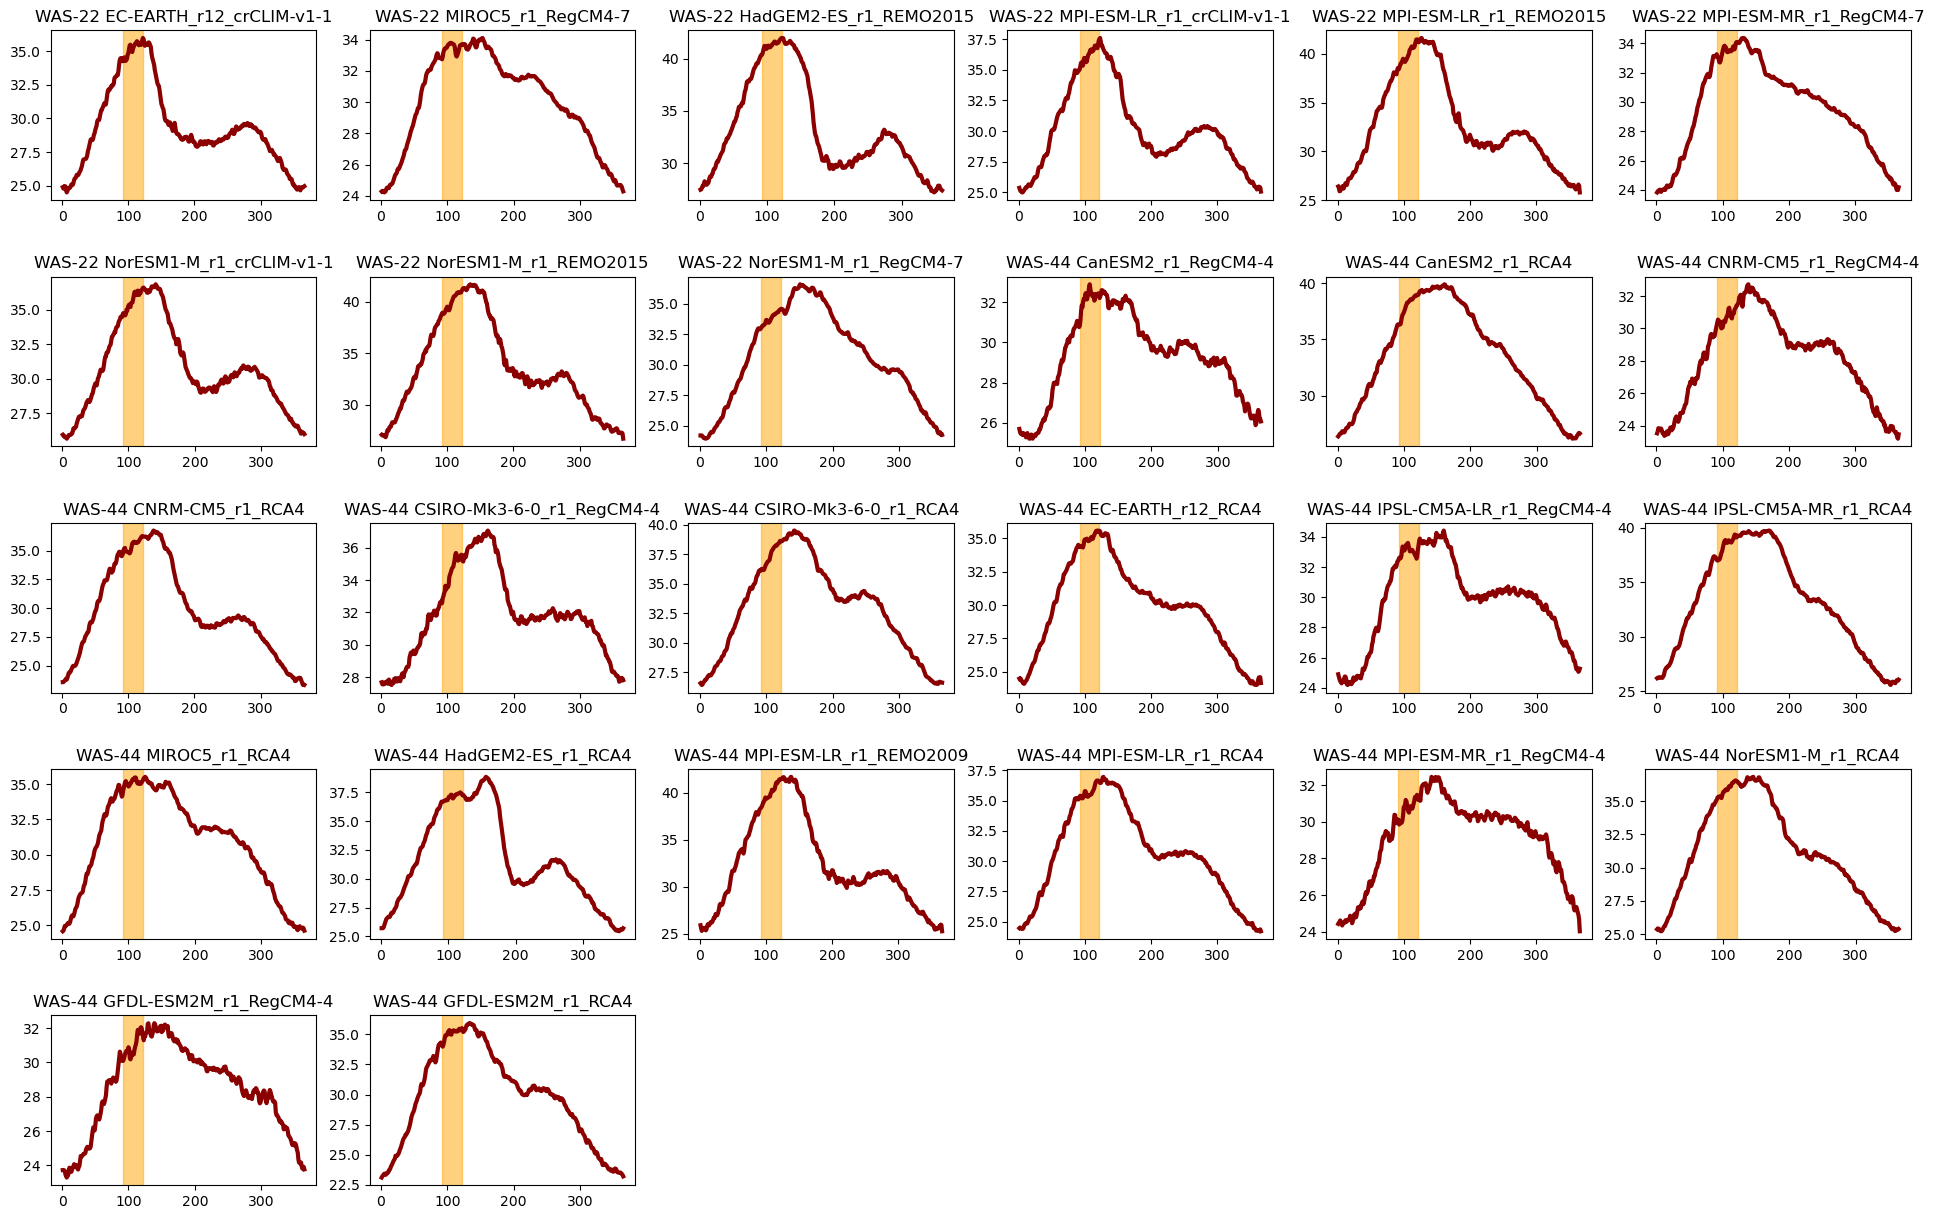

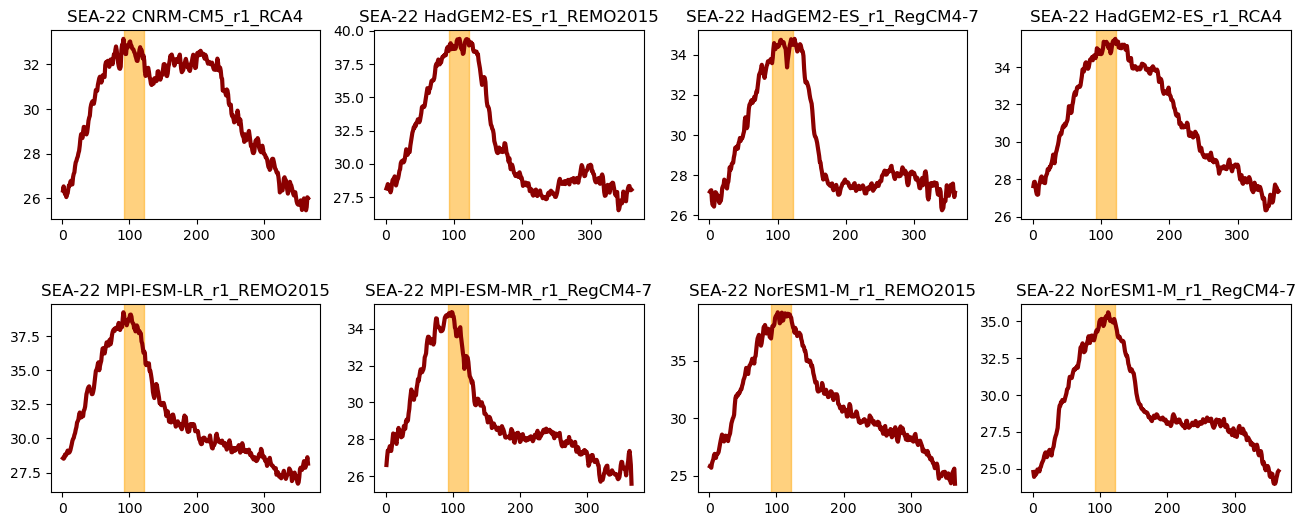

In [209]:
for region in ["ib-ext-tasmax", "ib-trop-tasmax", "tasmax"][1:]:
    fl = sorted(glob.glob("cordex/sc-"+region+"*"))
    
    if region == "tasmax":
        nc = 4
    else:
        nc = 6
    nr = int(np.ceil(len(fl) / nc))
    
    fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*4,nr*3), dpi = 100)
    plt.subplots_adjust(hspace = 0.45)
    
    for i in range(len(fl)):
        fnm = fl[i]
        ax = fig.axes[i]
        da = convert_units_to(xr.open_dataset(fnm).tasmax, "degC")
        
        ax.plot(da.dayofyear, da, lw = 3, zorder = 99, color = "darkred")
        # ax.plot(era.dayofyear, era - era.mean(), color = "k", lw = 1)
        ax.set_title(fnm.split("_")[1]+" "+cordex_model(fnm))
        
        # highlight April
        ylim = ax.get_ylim()
        ax.add_patch(Rectangle((datetime(2020,4,1).timetuple().tm_yday, -10), width = 30, height = 100, color = "orange", alpha = 0.5))
        ax.set_ylim(ylim)
        
    if len(fl) < (nr * nc):
        for ax in fig.axes[len(fl):]: ax.set_axis_off()
    
    plt.savefig("fig/seasonal_"+region+"_cordex.png")

---
## **Relative humidity & heat index using xclim**

In [72]:
from xclim.indicators.atmos import relative_humidity_from_dewpoint, heat_index

In [120]:
t2m = xr.open_dataset("data/era5_t2m_2023_Asia.nc").t2m
tdew = xr.open_dataset("data/era5_tdew_2023_Asia.nc").tdew
tmax = xr.open_dataset("data/era5_tmax_2023_Asia.nc").tmax

rh_bohren = relative_humidity_from_dewpoint(tas = t2m, tdps = tdew, method = "bohren98")

hi = heat_index(tas = tmax, hurs = rh_bohren)

sf_ext = gpd.read_file("sf_indiabangladesh-tropical-exterior")
sf_tl = gpd.read_file("sf_ThlndLaos")

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/xclim/core/cfchecks.py:48: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])


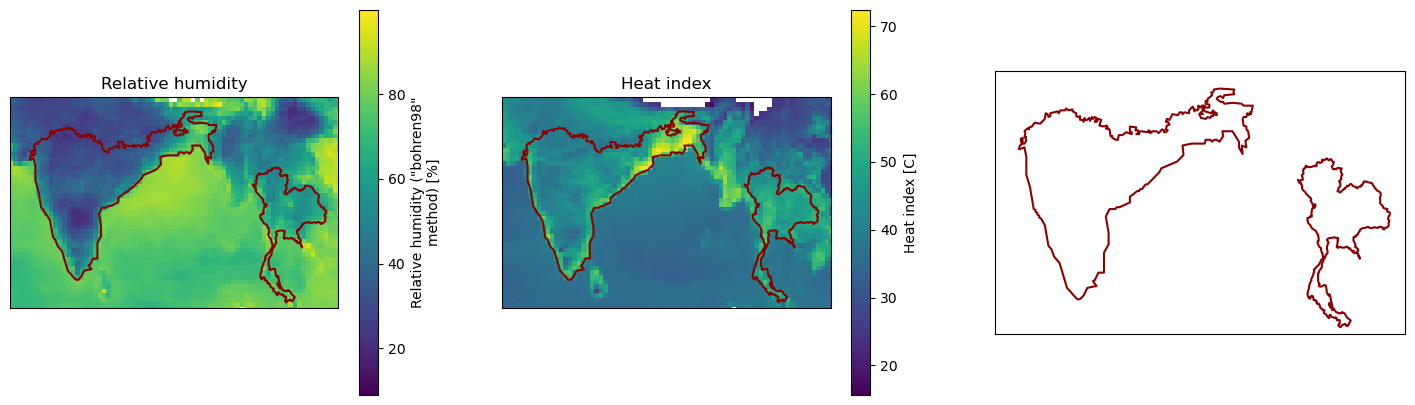

In [125]:
fig, axs = plt.subplots(ncols = 3, dpi = 100, figsize = (18,5), subplot_kw = {"projection" : cartopy.crs.PlateCarree(), "extent" : (70,107,5,27)})

rh_bohren.sel(time = "2023-04-17").plot(ax = axs[0]); axs[0].set_title("Relative humidity")
hi.sel(time = "2023-04-17").plot(ax = axs[1]); axs[1].set_title("Heat index")

for ax in axs: 
    sf_ext.boundary.plot(ax = ax, color = "darkred")
    sf_tl.boundary.plot(ax = ax, color = "darkred")

In [134]:
hi_ts = hi.where(regionmask.mask_3D_geopandas(sf_ext, hi.lon, hi.lat, drop = False).squeeze(drop = True)).mean(["lon", "lat"])
plt.step(hi_ts.time, hi_ts)

In [185]:
mhi = xr.open_dataset("data/era5_hi_2023_Asia.nc").hi

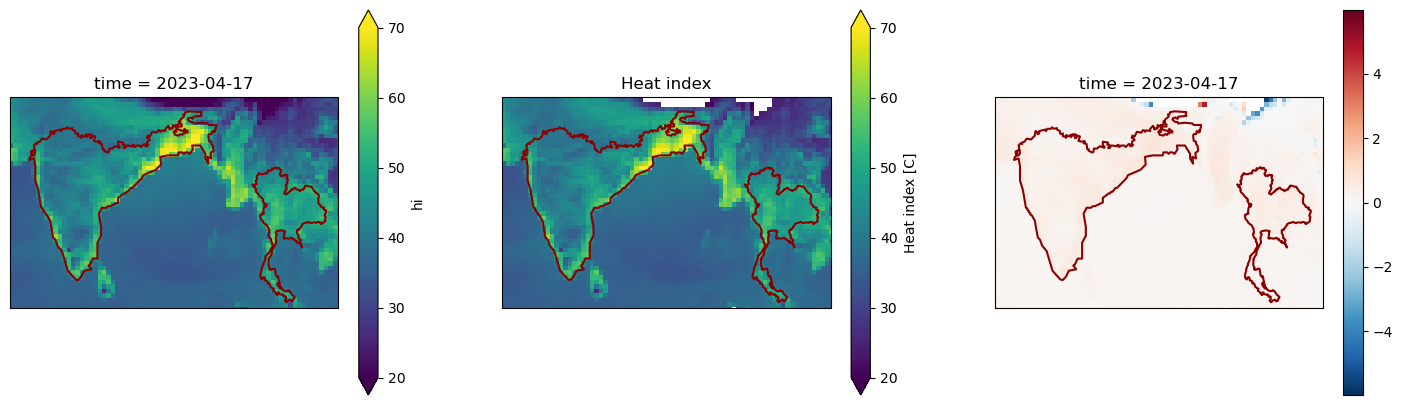

In [194]:
fig, axs = plt.subplots(ncols = 3, dpi = 100, figsize = (18,5), subplot_kw = {"projection" : cartopy.crs.PlateCarree(), "extent" : (70,107,5,27)})

mhi.sel(time = "2023-04-17").plot(ax = axs[0], vmin = 20, vmax = 70)
hi.sel(time = "2023-04-17").plot(ax = axs[1], vmin = 20, vmax = 70); axs[1].set_title("Heat index")
(mhi - hi).sel(time = "2023-04-17").plot(ax = axs[2])

for ax in axs: 
    sf_ext.boundary.plot(ax = ax, color = "darkred")
    sf_tl.boundary.plot(ax = ax, color = "darkred")

## **Stations**

In [5]:
fl = glob.glob("data/GTS_WMO-NCMRWF_*.nc")
fl = [fnm for fnm in fl if not re.sub(".+dailyHI_", "", fnm)[:-3] in ["NUMGAMBAKKAM", "KOLKATA_ALIPORE", "DIAMOND_HARBOUR"]]

### **Station locations**

In [6]:
px = {re.sub(".nc", "", re.sub(".+dailyHI_", "", fnm)) : [float(fnm.split("_")[3][:-1]), float(fnm.split("_")[2][:-1])] for fnm in fl}

In [7]:
ib_ext = gpd.read_file("sf_indiabangladesh-tropical-exterior")
ib_int = gpd.read_file("sf_indiabangladesh-tropical_hole")

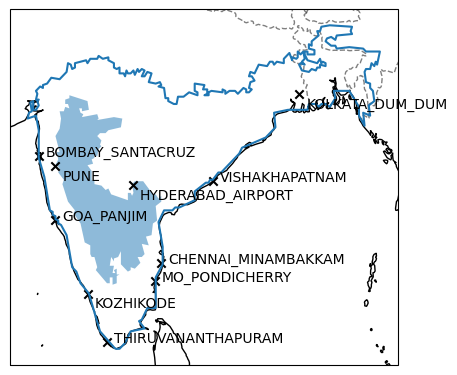

In [53]:
fig, ax = plt.subplots(figsize = (5,5), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

ax.coastlines(color = "k")
ax.add_feature(cartopy.feature.BORDERS, alpha = 0.5, ls = "--")
ib_ext.boundary.plot(ax = ax)
ib_int.plot(ax = ax, alpha = 0.5)

# ax.annotate(k, *v, textcoords="offset points", xytext=(-10,-3), ha = 'left')
[ax.annotate(k, (v[0], v[1]), textcoords="offset points", xytext=(5,0), ha = 'left') for k, v in px.items() if not k in ["KOZHIKODE", "PUNE", "HYDERABAD_AIRPORT", "KOLKATA_DUM_DUM"]]
[ax.annotate(k, (v[0], v[1]), textcoords="offset points", xytext=(5,-10), ha = 'left') for k, v in px.items() if k in ["KOZHIKODE", "PUNE", "HYDERABAD_AIRPORT", "KOLKATA_DUM_DUM"]]

[plt.scatter(*v, marker = "x", color = "k") for k, v in px.items()]

plt.savefig("fig/station-locations.png")

### **Trends in station data**

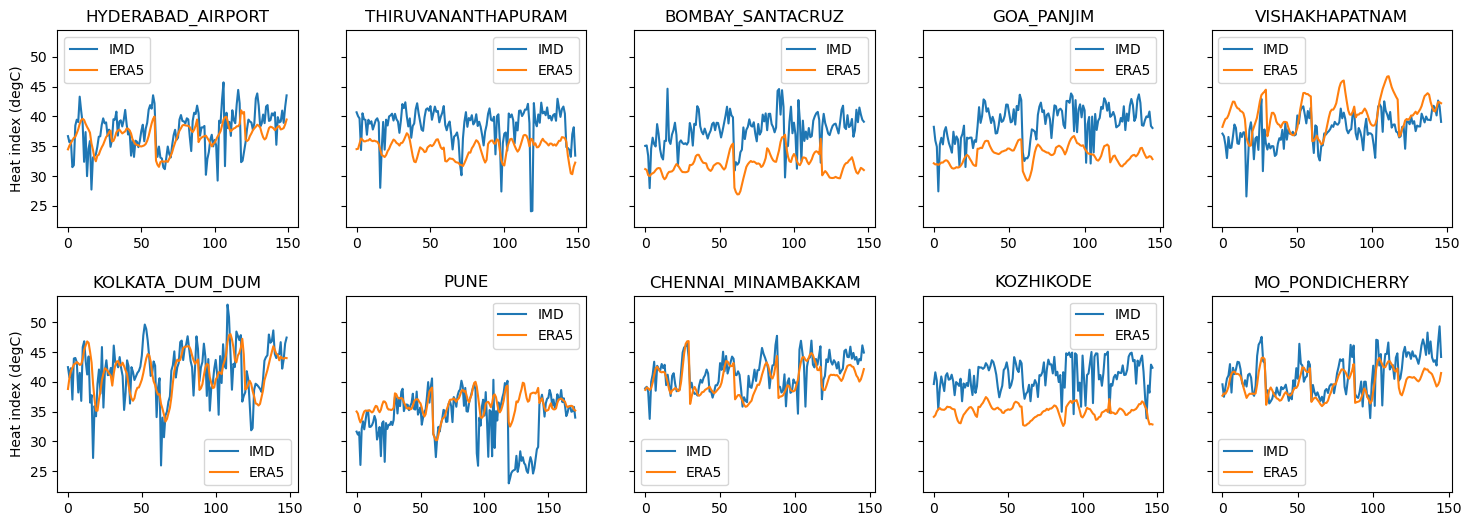

In [25]:
era = xr.open_dataset("data/HI_April_rollingmean4_Asia.nc").hi

fig, axs = plt.subplots(ncols = 5, nrows = 2, figsize = (18,6), dpi = 100, sharey = True)
plt.subplots_adjust(hspace = 0.35)

for i in range(len(fl)):
    
    ax = fig.axes[i]
    fnm = fl[i]
    
    lon, lat = [float(fnm.split("_")[3][:-1]), float(fnm.split("_")[2][:-1])]
    stn = re.sub(".nc", "", re.sub(".+dailyHI_", "", fnm))
    
    ts = xr.open_dataset(fnm).hi
    era_ts = nearest_px(lon, lat, era, xcoord = "lon", ycoord = "lat").sel(time = ts.time)
    
    ax.plot(ts, label = "IMD")
    ax.plot(era_ts, label = "ERA5")
    ax.set_title(stn)

    ax.legend()
    
for i in range(len(fl), len(fig.axes)): fig.axes[i].set_axis_off()

axs[0,0].set_ylabel("Heat index (degC)")
axs[1,0].set_ylabel("Heat index (degC)")

plt.savefig("fig/station-vs-era5.png")

/tmp/ipykernel_23103/533986228.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
/tmp/ipykernel_23103/533986228.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
/tmp/ipykernel_23103/533986228.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
/tmp/ipykernel_23103/533986228.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
/tmp/ipykernel_23103/533986228.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
/tmp/ipykernel_23103/533986228.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xtic

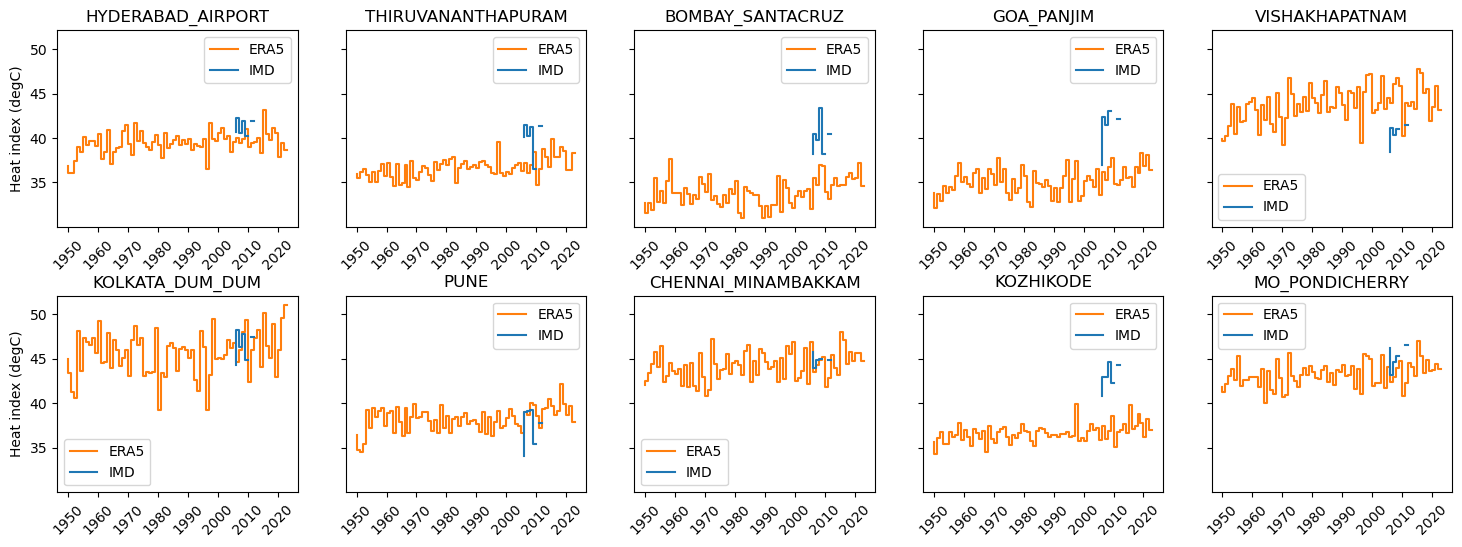

In [62]:
fig, axs = plt.subplots(ncols = 5, nrows = 2, figsize = (18,6), dpi = 100, sharey = True)
plt.subplots_adjust(hspace = 0.35)

for i in range(len(fl)):
    
    ax = fig.axes[i]
    fnm = fl[i]
    
    lon, lat = [float(fnm.split("_")[3][:-1]), float(fnm.split("_")[2][:-1])]
    stn = re.sub(".nc", "", re.sub(".+dailyHI_", "", fnm))
    
    ts = xr.open_dataset(fnm).hi.rolling(time = 4).mean().resample(time = "AS-JAN").max()
    era_ts = nearest_px(lon, lat, era, xcoord = "lon", ycoord = "lat").resample(time = "AS-JAN").max()
    
    ax.step(era_ts.time, era_ts, label = "ERA5", color = "tab:orange")
    ax.step(ts.time, ts, label = "IMD")
    ax.set_title(stn)

    ax.legend()
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
    
for i in range(len(fl), len(fig.axes)): fig.axes[i].set_axis_off()

axs[0,0].set_ylabel("Heat index (degC)")
axs[1,0].set_ylabel("Heat index (degC)")

plt.savefig("fig/tx4x_station-vs-era5.png")